In [6]:
import json

In [7]:
def get_scores_prompting(task, dataset, n_shot, base_path="../../zero-shot-absa-quad/generations/zeroshot/", data_type="test"):
    power, vram, times = [], [], []
    n_samples = 0

    for seed in range(5):
        file_path = f"{base_path}/{task}_{dataset}_{data_type}_gemma3:27b_{seed}{'_label' if data_type == 'test' else ''}_{n_shot}_PERFORMANCE.json"
        with open(file_path, "r") as f:
            data = json.load(f)
            n_samples += len(data)
            power.extend(ex["avg_gpu_power_eval_W"] for ex in data)
            vram.extend(ex["avg_gpu_vram_eval_MB"] for ex in data)
            times.extend(ex["total_time_eval"] for ex in data)

    return {
        "avg_gpu_power_eval_W": sum(power) / len(power),
        "avg_gpu_vram_eval_MB": sum(vram) / len(vram),
        "total_time_eval": sum(times) * 20 / 60, # 60 seconds to minutes
        "n_samples": n_samples * 20 / 5,
        "kWH": ((((sum(power) / len(power)) * sum(times)) * 20)) / (36 * 100000)
    }

def get_scores_prompting_all(task, n_shot, base_path="../../zero-shot-absa-quad/generations/zeroshot/", data_type="test"):
    datasets = ["rest15", "rest16", "hotels", "coursera", "flightabsa"]
    all_stats = [get_scores_prompting(task, ds, n_shot, base_path, data_type) for ds in datasets]

    return {
        key: sum(stat[key] for stat in all_stats) / len(all_stats)
        for key in all_stats[0]
    }


In [8]:
def get_scores_la(
    task,
    dataset,
    n_shot,
    method,
    base_path="../_out_fine_tunings/01_llm_annotate_train",
):
    (
        avg_gpu_vram_train_MB,
        avg_gpu_power_train_W,
        total_time_eval,
        total_time_train,
        avg_gpu_vram_eval_MB,
        avg_gpu_power_eval_W,
    ) = ([], [], [], [], [], [])
    n_samples = 0

    for seed in range(5):
        file_path = f"{base_path}/{method}_full_{task}_{n_shot}_{dataset}_{seed}_PERFORMANCE.json"
        
        with open(file_path, "r") as f:
            data = json.load(f)
            n_samples += len(data["all_preds"])
            avg_gpu_vram_train_MB.append(data["avg_gpu_vram_train_MB"])
            avg_gpu_power_train_W.append(data["avg_gpu_power_train_W"])
            total_time_eval.append(data["total_time_eval"])
            total_time_train.append(data["total_time_train"])
            avg_gpu_vram_eval_MB.append(data["avg_gpu_vram_eval_MB"])
            avg_gpu_power_eval_W.append(data["avg_gpu_power_eval_W"])
            
    n_dev = 10 if method == "paraphrase" else 20
    
    return {
        "avg_gpu_vram_train_MB": sum(avg_gpu_vram_train_MB) / 5,
        "avg_gpu_power_train_W": sum(avg_gpu_power_train_W) / 5,
        "total_time_eval": sum(total_time_eval) / 5 / 60 ,
        "total_time_train": sum(total_time_train) / 5 * n_dev / 60,
        "avg_gpu_vram_eval_MB": sum(avg_gpu_vram_eval_MB) / 5,
        "avg_gpu_power_eval_W": sum(avg_gpu_power_eval_W) / 5,
        "n_samples_test": n_samples / 5,
        "kWH_train": (sum(avg_gpu_power_train_W) / 5 * sum(total_time_train) / 5 * n_dev ) / (36 * 100000),
        "kWH_eval": (sum(avg_gpu_power_eval_W) / 5 * sum(total_time_eval) / 5 ) / (36 * 100000),
    }
    
def get_scores_la_all(
    task,
    n_shot,
    method,
    base_path="../_out_fine_tunings/01_llm_annotate_train",
):
    datasets = ["rest15", "rest16", "hotels", "coursera", "flightabsa"]
    all_stats = [get_scores_la(task, ds, n_shot, method, base_path) for ds in datasets]

    return {
        key: sum(stat[key] for stat in all_stats) / len(all_stats)
        for key in all_stats[0]
    }

In [9]:
get_scores_la_all("asqp", 0, "dlo")

{'avg_gpu_vram_train_MB': 14314.948497117342,
 'avg_gpu_power_train_W': 152.1884994459477,
 'total_time_eval': 3.274790122350057,
 'total_time_train': 67.5902837530772,
 'avg_gpu_vram_eval_MB': 15108.620183531555,
 'avg_gpu_power_eval_W': 107.63152346988386,
 'n_samples_test': 453.6,
 'kWH_train': 0.1695060041436463,
 'kWH_eval': 0.005869187272358828}

In [10]:
# Dictionary zum Tracking wann LA-ABSA effizienter ist als Gemma 3
# 24 Kombinationen: 3 shots (0,10,50) x 2 tasks (asqp,tasd) x 2 methods (paraphrase,dlo) x 2 metrics (energy,time)
efficiency_crossover = {}

def find_line_intersection(x1, y1, x2, y2):
    """
    Findet den Schnittpunkt von zwei Linien.
    Jede Linie wird durch zwei Punkte definiert: (x1[0],y1[0]) zu (x1[1],y1[1]) und (x2[0],y2[0]) zu (x2[1],y2[1])
    """
    # Linie 1: y = m1*x + b1
    if x1[1] - x1[0] == 0:
        return None  # Vertikale Linie
    m1 = (y1[1] - y1[0]) / (x1[1] - x1[0])
    b1 = y1[0] - m1 * x1[0]
    
    # Linie 2: y = m2*x + b2
    if x2[1] - x2[0] == 0:
        return None  # Vertikale Linie
    m2 = (y2[1] - y2[0]) / (x2[1] - x2[0])
    b2 = y2[0] - m2 * x2[0]
    
    # Schnittpunkt: m1*x + b1 = m2*x + b2
    if m1 == m2:
        return None  # Parallele Linien
    
    x_intersect = (b2 - b1) / (m1 - m2)
    y_intersect = m1 * x_intersect + b1
    
    return x_intersect, y_intersect

In [11]:
def print_efficiency_analysis():
    """Druckt eine Analyse des Efficiency Crossover Dictionaries"""
    print("=" * 80)
    print("EFFICIENCY CROSSOVER ANALYSIS: Ab wann ist LA-ABSA effizienter als Gemma-3?")
    print("=" * 80)
    print("Format: [Shots]_[Task]_[Method]_[Metric] -> Anzahl Samples ab wann LA-ABSA besser")
    print("None = LA-ABSA ist nie besser, 0 = LA-ABSA ist von Anfang an besser")
    print("-" * 80)
    
    # Sortiere nach logischer Reihenfolge
    shots = ["0", "10", "50"]
    tasks = ["asqp", "tasd"]
    methods = ["paraphrase", "dlo"]
    metrics = ["energy", "time"]
    
    for metric in metrics:
        print(f"\n{metric.upper()} EFFICIENCY:")
        print("-" * 40)
        
        for shot in shots:
            print(f"\n{shot}-shot:")
            for task in tasks:
                for method in methods:
                    key = f"{shot}_{task}_{method}_{metric}"
                    value = efficiency_crossover.get(key, "Nicht gefunden")
                    
                    if value is None:
                        status = "❌ Nie effizienter"
                    elif value == 0:
                        status = "✅ Sofort effizienter"
                    else:
                        status = f"⚡ Ab {value:,} Samples"
                    
                    print(f"  {task.upper()}-{method}: {status}")
    
    print("\n" + "=" * 80)
    print("ZUSAMMENFASSUNG:")
    print("=" * 80)
    
    # Statistiken
    total_cases = len(efficiency_crossover)
    always_better = sum(1 for v in efficiency_crossover.values() if v == 0)
    never_better = sum(1 for v in efficiency_crossover.values() if v is None)
    sometimes_better = total_cases - always_better - never_better
    
    print(f"Gesamt analysierte Fälle: {total_cases}")
    print(f"LA-ABSA sofort besser: {always_better} ({always_better/total_cases*100:.1f}%)")
    print(f"LA-ABSA nie besser: {never_better} ({never_better/total_cases*100:.1f}%)")
    print(f"LA-ABSA ab bestimmter Anzahl besser: {sometimes_better} ({sometimes_better/total_cases*100:.1f}%)")
    
    return efficiency_crossover

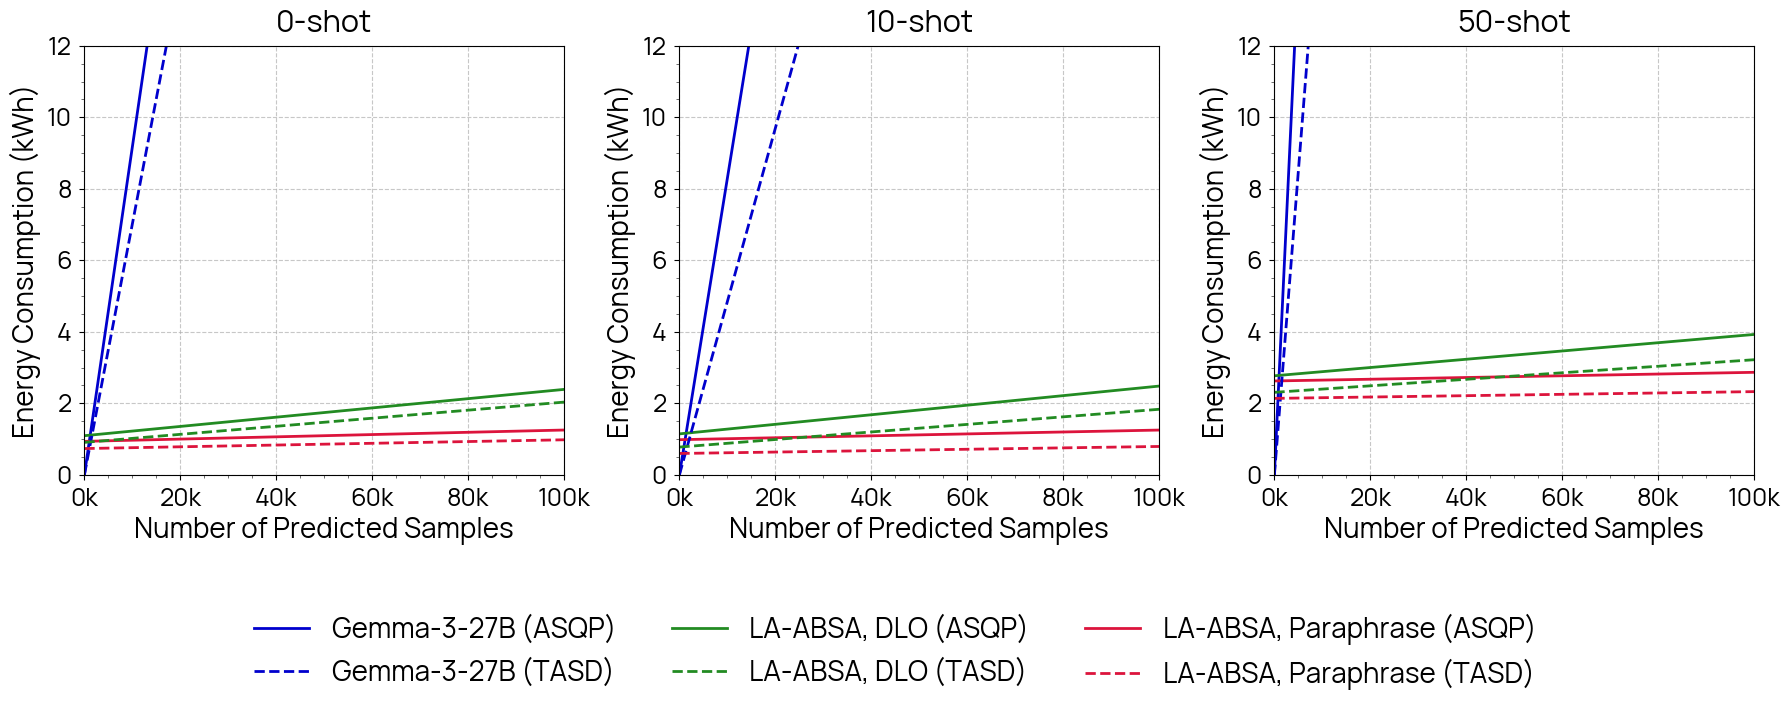

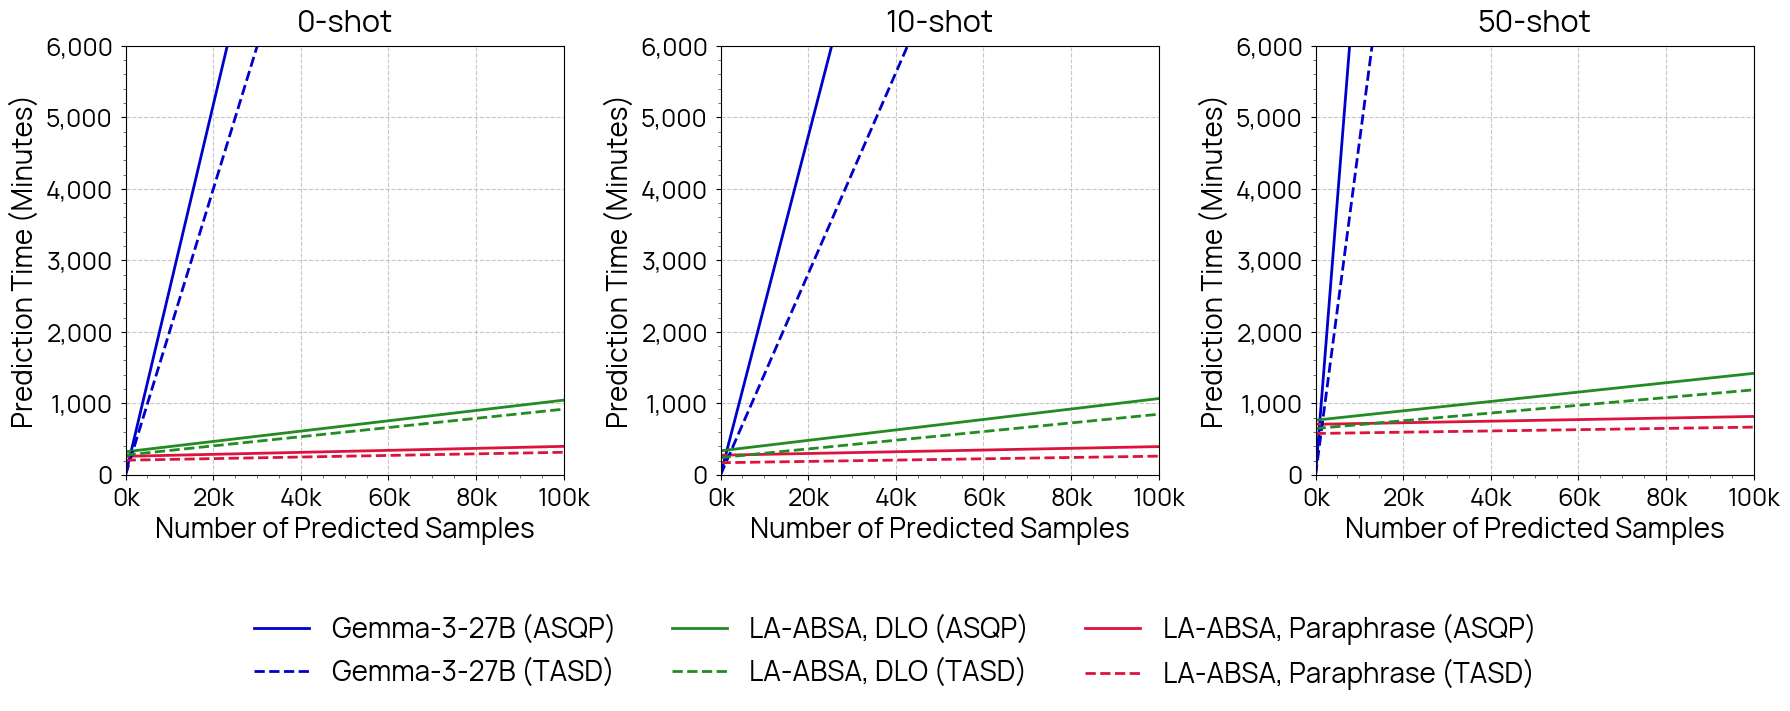

EFFICIENCY CROSSOVER ANALYSIS: Ab wann ist LA-ABSA effizienter als Gemma-3?
Format: [Shots]_[Task]_[Method]_[Metric] -> Anzahl Samples ab wann LA-ABSA besser
None = LA-ABSA ist nie besser, 0 = LA-ABSA ist von Anfang an besser
--------------------------------------------------------------------------------

ENERGY EFFICIENCY:
----------------------------------------

0-shot:
  ASQP-paraphrase: ⚡ Ab 1,026 Samples
  ASQP-dlo: ⚡ Ab 1,212 Samples
  TASD-paraphrase: ⚡ Ab 1,054 Samples
  TASD-dlo: ⚡ Ab 1,316 Samples

10-shot:
  ASQP-paraphrase: ⚡ Ab 1,192 Samples
  ASQP-dlo: ⚡ Ab 1,406 Samples
  TASD-paraphrase: ⚡ Ab 1,242 Samples
  TASD-dlo: ⚡ Ab 1,642 Samples

50-shot:
  ASQP-paraphrase: ⚡ Ab 925 Samples
  ASQP-dlo: ⚡ Ab 979 Samples
  TASD-paraphrase: ⚡ Ab 1,260 Samples
  TASD-dlo: ⚡ Ab 1,365 Samples

TIME EFFICIENCY:
----------------------------------------

0-shot:
  ASQP-paraphrase: ⚡ Ab 1,009 Samples
  ASQP-dlo: ⚡ Ab 1,286 Samples
  TASD-paraphrase: ⚡ Ab 1,034 Samples
  TASD-dlo: ⚡ Ab 1

{'0_asqp_paraphrase_energy': 1026,
 '0_asqp_dlo_energy': 1212,
 '0_tasd_paraphrase_energy': 1054,
 '0_tasd_dlo_energy': 1316,
 '10_asqp_paraphrase_energy': 1192,
 '10_asqp_dlo_energy': 1406,
 '10_tasd_paraphrase_energy': 1242,
 '10_tasd_dlo_energy': 1642,
 '50_asqp_paraphrase_energy': 925,
 '50_asqp_dlo_energy': 979,
 '50_tasd_paraphrase_energy': 1260,
 '50_tasd_dlo_energy': 1365,
 '0_asqp_paraphrase_time': 1009,
 '0_asqp_dlo_time': 1286,
 '0_tasd_paraphrase_time': 1034,
 '0_tasd_dlo_time': 1434,
 '10_asqp_paraphrase_time': 1169,
 '10_asqp_dlo_time': 1467,
 '10_tasd_paraphrase_time': 1219,
 '10_tasd_dlo_time': 1799,
 '50_asqp_paraphrase_time': 916,
 '50_asqp_dlo_time': 998,
 '50_tasd_paraphrase_time': 1246,
 '50_tasd_dlo_time': 1411}

In [12]:
import matplotlib.pyplot as plt
from matplotlib import font_manager
import numpy as np
import matplotlib.ticker as mticker

# Globale Variablen für das 1x3 Layout
fig = None
axes = None
subplot_counter = 0
all_handles = []
all_labels = []
current_plot_type = None

def setup_1x3_plot(plot_type):
    """Initialisiert das 1x3 Plot Layout"""
    global fig, axes, subplot_counter, current_plot_type
    
    font_path = '_fonts/Manrope-Regular.ttf'
    font_manager.fontManager.addfont(font_path)
    prop = font_manager.FontProperties(fname=font_path)

    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = prop.get_name()
    plt.style.use('seaborn-v0_8-paper') 

    fig, axes = plt.subplots(1, 3, figsize=(18, 6), dpi=100)
    subplot_counter = 0
    current_plot_type = plot_type
    
    return fig, axes

def draw_plot(title_x, title_y, plot_title, data=[], maximum_y=1000, maximum_x=1000):
    global fig, axes, subplot_counter, all_handles, all_labels, efficiency_crossover
    
    # Bestimme die Position im 1x3 Grid
    ax = axes[subplot_counter]
    
    # Bestimme Metrik und Shot-Count aus dem Plot-Titel
    metric = "energy" if "Energy" in title_y else "time"
    shot_count = plot_title.split("-")[0]  # "0-shot" -> "0"
    
    # Sammle Linien für Schnittpunkt-Berechnung
    gemma_lines = {}  # task -> (x, y)
    la_lines = {}     # (task, method) -> (x, y)
    
    # Plot die Daten (ohne Punkte)
    for d in data:
        x = np.array(d["x"])
        y = np.array(d["y"])
        
        # Keine Punkte mehr, nur Linien
        if x[1] > x[0]:
            N_TIMES_SCALE = 1000   
            x[1] = x[1] * N_TIMES_SCALE
            y[1] = y[1] + (y[1] - y[0]) * (N_TIMES_SCALE-1)
        
        # Bestimme Linienstil basierend auf Task
        linestyle = '--' if d.get("task") == "tasd" else '-'
         
        line = ax.plot(x, y, color=d["line_color"], linewidth=2, 
                      linestyle=linestyle, label=d["legend_title_line"])
        
        # Sammle Linien-Daten für Schnittpunkt-Berechnung
        task = d.get("task")
        if "Gemma-3-27B" in d["legend_title_line"]:
            gemma_lines[task] = (x, y)
        elif "LA-ABSA" in d["legend_title_line"]:
            method = "paraphrase" if "Paraphrase" in d["legend_title_line"] else "dlo"
            la_lines[(task, method)] = (x, y)
        
        # Sammle Handles und Labels für die gemeinsame Legende
        if d["legend_title_line"] not in all_labels:
            all_handles.append(line[0])
            all_labels.append(d["legend_title_line"])
    
    # Berechne Schnittpunkte für alle Kombinationen
    for task in ["asqp", "tasd"]:
        for method in ["paraphrase", "dlo"]:
            if task in gemma_lines and (task, method) in la_lines:
                gemma_x, gemma_y = gemma_lines[task]
                la_x, la_y = la_lines[(task, method)]
                
                intersection = find_line_intersection(gemma_x, gemma_y, la_x, la_y)
                
                # Erstelle den Dictionary-Key
                key = f"{shot_count}_{task}_{method}_{metric}"
                
                if intersection is not None:
                    x_cross, y_cross = intersection
                    # Speichere den x-Wert (Anzahl Samples) wo LA-ABSA effizienter wird
                    efficiency_crossover[key] = int(x_cross) if x_cross > 0 else None
                else:
                    # Keine Kreuzung gefunden - prüfe ob LA-ABSA immer besser oder schlechter ist
                    # Vergleiche y-Werte bei maximum_x
                    gemma_y_end = gemma_y[1]
                    la_y_end = la_y[1]
                    
                    if la_y_end < gemma_y_end:
                        efficiency_crossover[key] = 0  # LA-ABSA ist von Anfang an besser
                    else:
                        efficiency_crossover[key] = None  # LA-ABSA ist nie besser

    ax.set_xlabel(title_x, fontsize=20)
    ax.set_ylabel(title_y, fontsize=20)
    ax.set_title(plot_title, fontsize=22, pad=10)

    ax.grid(True, linestyle='--', alpha=0.7)
    ax.minorticks_on()

    ax.set_xlim(0, maximum_x)
    ax.set_ylim(0, maximum_y)
    
    ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: str(int(x / 1000))+"k"))
    ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    
    ax.tick_params(axis='both', which='major', labelsize=18)
    
    subplot_counter += 1
    
    # Wenn alle 3 Plots erstellt wurden, füge die gemeinsame Legende hinzu und speichere
    if subplot_counter == 3:
        finalize_plot()

def finalize_plot():
    """Fügt die gemeinsame Legende hinzu und speichert das Plot"""
    global fig, all_handles, all_labels, current_plot_type
    
    sorted_handles_labels = sorted(zip(all_labels, all_handles), key=lambda x: x[0])
    all_labels, all_handles = zip(*sorted_handles_labels)
    
    # Gemeinsame Legende unterhalb der Plots
    fig.legend(
        all_handles, 
        all_labels,
        loc='lower center',
        bbox_to_anchor=(0.5, -0.2),
        ncol=3,  # 3 Spalten für bessere Platznutzung
        fontsize=20,
        frameon=False
    )
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.2)  # Platz für die Legende
    
    # Speichere mit entsprechendem Namen
    filename = f"_out_table/prediction_{current_plot_type}_plots_1x3.pdf"
    plt.savefig(filename, format="pdf", dpi=300, bbox_inches="tight")
    plt.show()
    
    # Reset für nächste Verwendung
    reset_plot_state()

def reset_plot_state():
    """Setzt den Plot-Status zurück"""
    global fig, axes, subplot_counter, all_handles, all_labels, current_plot_type
    fig = None
    axes = None
    subplot_counter = 0
    all_handles = []
    all_labels = []
    current_plot_type = None

# Angepasste Farbpalette für bessere Unterscheidung
line_colors = {
    "dlo": "#228B22",       # Waldgrün
    "paraphrase": "#DC143C",  # Karmesinrot
    "gemma3:27b": "#0000CD",  # Mittelblau
}

model_key_to_name = {
    "paraphrase": "Paraphrase",
    "dlo": "DLO"
}

def get_scores_for_task(task, shot_count, method=None, data_type=None):
    """Hilfsfunktion für einzelne Tasks"""
    if method is None:
        # Standard prompting
        return get_scores_prompting_all(task, shot_count)
    elif method == "annotate":
        # LLM annotate train
        return get_scores_prompting_all(
            task,
            shot_count,
            base_path="../_out_synthetic_examples/01_llm_annotate_train",
            data_type="train",
        )
    else:
        # LA with specified method (paraphrase or dlo)
        return get_scores_la_all(task, shot_count, method)

def create_all_plots():
    """Erstellt alle Plots - zwei PDFs mit jeweils drei Plots (separate ASQP und TASD Lines)"""
    
    # Reset das Efficiency Dictionary
    global efficiency_crossover
    efficiency_crossover = {}
    
    # Erstelle Plots für Energy Consumption
    setup_1x3_plot("energy")
    
    for shot_count in [0, 10, 50]:
        # Get scores for both tasks separately
        plot_data = []
        
        for task in ["asqp", "tasd"]:
            # Standard prompting (Gemma-3-27B gibt es immer)
            gemma_scores = get_scores_for_task(task, shot_count)
            task_label = "ASQP" if task == "asqp" else "TASD"
            
            plot_data.append({
                "x": [0, gemma_scores["n_samples"]],
                "y": [0, gemma_scores["kWH"]],
                "legend_title_line": f"Gemma-3-27B ({task_label})",
                "line_color": line_colors[f"gemma3:27b"],
                "task": task
            })
            
            # LA Methoden (DLO und LLaMA gibt es bei allen Shot-Counts)
            for method in ["dlo", "paraphrase"]:
                annotate_scores = get_scores_for_task(task, shot_count, "annotate")
                method_scores = get_scores_for_task(task, shot_count, method)
                
                plot_data.append({
                    "x": [0, method_scores["n_samples_test"]],
                    "y": [
                        annotate_scores["kWH"] + method_scores["kWH_train"],
                        annotate_scores["kWH"] + method_scores["kWH_train"] + method_scores["kWH_eval"],
                    ],
                    "legend_title_line": f"LA-ABSA, {model_key_to_name[method]} ({task_label})",
                    "line_color": line_colors[f"{method}"],
                    "task": task
                })
        
        draw_plot(
            "Number of Predicted Samples",
            "Energy Consumption (kWh)",
            f"{shot_count}-shot",
            plot_data,
            maximum_y=12,  # Angepasst für separate Tasks
            maximum_x=100000,
        )

    # Erstelle Plots für Prediction Time
    setup_1x3_plot("time")
    
    for shot_count in [0, 10, 50]:
        # Get scores for both tasks separately
        plot_data = []
        
        for task in ["asqp", "tasd"]:
            # Standard prompting (Gemma-3-27B gibt es immer)
            gemma_scores = get_scores_for_task(task, shot_count)
            task_label = "ASQP" if task == "asqp" else "TASD"
            
            plot_data.append({
                "x": [0, gemma_scores["n_samples"]],
                "y": [0, gemma_scores["total_time_eval"]],
                "legend_title_line": f"Gemma-3-27B ({task_label})",
                "line_color": line_colors[f"gemma3:27b"],
                "task": task
            })
            
            # LA Methoden (DLO und LLaMA gibt es bei allen Shot-Counts)
            for method in ["dlo", "paraphrase"]:
                annotate_scores = get_scores_for_task(task, shot_count, "annotate")
                method_scores = get_scores_for_task(task, shot_count, method)
                
                plot_data.append({
                    "x": [0, method_scores["n_samples_test"]],
                    "y": [
                        annotate_scores["total_time_eval"] + method_scores["total_time_train"],
                        annotate_scores["total_time_eval"] + method_scores["total_time_train"] + method_scores["total_time_eval"],
                    ],
                    "legend_title_line": f"LA-ABSA, {model_key_to_name[method]} ({task_label})",
                    "line_color": line_colors[f"{method}"],
                    "task": task
                })
        
        draw_plot(
            "Number of Predicted Samples",
            "Prediction Time (Minutes)",
            f"{shot_count}-shot",
            plot_data,
            maximum_y=6000,  # Angepasst für separate Tasks
            maximum_x=100000,
        )

# Zum Ausführen rufen Sie einfach auf:
create_all_plots()

# Gebe die Efficiency-Analyse aus
print_efficiency_analysis()

In [13]:
# get_scores_prompting
# get_scores_la

In [14]:
TASKS = ["asqp", "tasd"]
DATASETS = ["rest15", "rest16", "hotels", "coursera", "flightabsa"]
N_SHOTS = [0, 10, 50]
BASELINES = ["dlo", "paraphrase"]

get_scores_la("asqp", "rest15", 50, "dlo"), get_scores_prompting("asqp", "rest15", 0)

({'avg_gpu_vram_train_MB': 14000.608695652172,
  'avg_gpu_power_train_W': 131.58749440052702,
  'total_time_eval': 3.714552973111471,
  'total_time_train': 41.80121339162191,
  'avg_gpu_vram_eval_MB': 14771.688062724163,
  'avg_gpu_power_eval_W': 108.64085079861889,
  'n_samples_test': 537.0,
  'kWH_train': 0.09167528221842138,
  'kWH_eval': 0.0067258699222561575},
 {'avg_gpu_power_eval_W': 213.6107878486679,
  'avg_gpu_vram_eval_MB': 18994.51149932295,
  'total_time_eval': 144.5291670958201,
  'n_samples': 520.0,
  'kWH': 0.5145498208408318})

In [15]:
TASKS = ["asqp", "tasd"]
DATASETS = ["rest15", "rest16", "hotels", "coursera", "flightabsa"]
N_SHOTS = [0, 10, 50]
BASELINES = ["dlo", "paraphrase"]

import pandas as pd
import numpy as np

def calculate_energy_consumption(scores_func, entry="kWH_eval", n_samples="n_samples_test", *args):
    """Calculate energy consumption per sample in mWh"""
    scores = scores_func(*args)
    # convert to mWh
    if entry == "kWH_eval":
       return scores[entry] * 1000 * 1000 / scores[n_samples]
    else:
       return scores[entry] / scores[n_samples]

def calculate_energy_consumption_prompting(scores_func, entry="kWH", n_samples="n_samples", *args):
    """Calculate energy consumption per sample in mWh for prompting"""
    scores = scores_func(*args)
    if entry == "kWH":
       return scores[entry] * 1000 * 1000 / scores[n_samples]
    else:
       return scores[entry] / scores[n_samples]

# Collect all data
all_data = []

# Process LA-ABSA baselines
baseline_names = {
    "dlo": "LA-ABSA (DLO)",
    "paraphrase": "LA-ABSA (Paraphrase)"
}

for baseline in BASELINES:
    row_data = {"Method": baseline_names[baseline]}
    
    for n_shot in N_SHOTS:
        # Collect values for each task across all datasets
        tasd_values = []
        asqp_values = []
        
        for dataset in DATASETS:
            tasd_val = calculate_energy_consumption(get_scores_la, "kWH_eval", "n_samples_test", "tasd", dataset, n_shot, baseline)
            asqp_val = calculate_energy_consumption(get_scores_la, "kWH_eval", "n_samples_test", "asqp", dataset, n_shot, baseline)
            
            tasd_values.append(tasd_val)
            asqp_values.append(asqp_val)
        
        # Calculate mean and std
        tasd_mean = np.mean(tasd_values)
        tasd_std = np.std(tasd_values)
        asqp_mean = np.mean(asqp_values)
        asqp_std = np.std(asqp_values)
        
        # Format as mean ± std
        row_data[f"{n_shot}_TASD"] = f"{tasd_mean:.2f} ± {tasd_std:.2f}"
        row_data[f"{n_shot}_ASQP"] = f"{asqp_mean:.2f} ± {asqp_std:.2f}"
    
    all_data.append(row_data)

# Process LLM-Prompting
row_data = {"Method": "LLM-Prompting"}

for n_shot in N_SHOTS:
    # Collect values for each task across all datasets
    tasd_values = []
    asqp_values = []
    
    for dataset in DATASETS:
        tasd_val = calculate_energy_consumption_prompting(get_scores_prompting, "kWH", "n_samples", "tasd", dataset, n_shot)
        asqp_val = calculate_energy_consumption_prompting(get_scores_prompting, "kWH", "n_samples", "asqp", dataset, n_shot)
        
        tasd_values.append(tasd_val)
        asqp_values.append(asqp_val)
    
    # Calculate mean and std
    tasd_mean = np.mean(tasd_values)
    tasd_std = np.std(tasd_values)
    asqp_mean = np.mean(asqp_values)
    asqp_std = np.std(asqp_values)
    
    # Format as mean ± std
    row_data[f"{n_shot}_TASD"] = f"{tasd_mean:.2f} ± {tasd_std:.2f}"
    row_data[f"{n_shot}_ASQP"] = f"{asqp_mean:.2f} ± {asqp_std:.2f}"

all_data.append(row_data)

# Create DataFrame
df = pd.DataFrame(all_data)

# Create multi-level columns
columns = [("", "Method")]
for n_shot in N_SHOTS:
    columns.append((str(n_shot), "TASD"))
    columns.append((str(n_shot), "ASQP"))

# Set up the DataFrame with proper column structure
df_formatted = pd.DataFrame(index=df.index)
df_formatted[("", "Method")] = df["Method"]

for n_shot in N_SHOTS:
    df_formatted[(str(n_shot), "TASD")] = df[f"{n_shot}_TASD"]
    df_formatted[(str(n_shot), "ASQP")] = df[f"{n_shot}_ASQP"]

# Create MultiIndex columns
df_formatted.columns = pd.MultiIndex.from_tuples(df_formatted.columns)

# Set the method names as index
df_formatted.set_index(("", "Method"), inplace=True)

# Also create a version that can be easily saved/exported
df_simple = df.copy()
df_simple.set_index("Method", inplace=True)

In [16]:
df_simple

,0_TASD,0_ASQP,10_TASD,10_ASQP,50_TASD,50_ASQP
Method,,,,,,
LA-ABSA (DLO),11.16 ± 0.72,13.06 ± 0.89,10.68 ± 2.11,13.19 ± 1.62,8.95 ± 0.85,11.65 ± 2.23
LA-ABSA (Paraphrase),2.47 ± 0.53,3.17 ± 0.31,1.96 ± 0.40,2.66 ± 0.28,1.83 ± 0.38,2.41 ± 0.46
LLM-Prompting,703.10 ± 63.97,912.25 ± 72.67,481.39 ± 46.11,843.68 ± 356.29,1688.76 ± 255.30,2963.65 ± 1360.88


In [17]:
# 1. Lade deine memory.txt
with open("01_muster_tex/memory.txt", "r") as f:
    memory_data = f.read()

# 2. Iteriere über die Methoden und Spalten und ersetze XXXX in Reihenfolge
methods = ["LA-ABSA (Paraphrase)", "LA-ABSA (DLO)", "LLM-Prompting"]
columns_order = ["0_TASD", "0_ASQP", "10_TASD", "10_ASQP", "50_TASD", "50_ASQP"]

for method in methods:
    for col in columns_order:
        value = df_simple.loc[method, col]
        memory_data = memory_data.replace("XXXX", value, 1)

print(memory_data)

\begin{tabular}{@{}lccccccc@{}}
\toprule
\multirow{2}{*}{\textbf{Method}} & \multicolumn{2}{c}{\textbf{0-shot}} & \multicolumn{2}{c}{\textbf{10-shot}} & \multicolumn{2}{c}{\textbf{50-shot}} \\
\cmidrule(lr){2-3} \cmidrule(lr){4-5} \cmidrule(lr){6-7}
 & \textbf{TASD} & \textbf{ASQP} & \textbf{TASD} & \textbf{ASQP} & \textbf{TASD} & \textbf{ASQP} \\
\midrule
LA-ABSA (Paraphrase) & 2.47 ± 0.53 & 3.17 ± 0.31 & 1.96 ± 0.40 & 2.66 ± 0.28 & 1.83 ± 0.38 & 2.41 ± 0.46 \\
LA-ABSA (DLO) & 11.16 ± 0.72 & 13.06 ± 0.89 & 10.68 ± 2.11 & 13.19 ± 1.62 & 8.95 ± 0.85 & 11.65 ± 2.23 \\
Gemma-3-27B ICL & 703.10 ± 63.97 & 912.25 ± 72.67 & 481.39 ± 46.11 & 843.68 ± 356.29 & 1688.76 ± 255.30 & 2963.65 ± 1360.88 \\
\bottomrule
\end{tabular}
